# Optimization

**Prerequisites**

- [Introduction to Numpy](numpy_arrays.ipynb)  
- [Applied Linear Algebra](applied_linalg.ipynb)  


**Outcomes**

- Perform optimization by hand using derivatives  
- Understand ideas from gradient descent  

In [1]:
# imports for later
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## What is optimization?

Optimization is the branch of mathematics focused on finding extreme values (max or min) of
functions

Optimization tools will show up in many places throughout this course, including:

- Building economic models in which individuals make decisions that maximize their utility  
- Building statistical models and maximizing the fit of these models by optimizing certain fit
  functions  


In this lecture, we will focus mostly the first in order to limit the number of
moving pieces, but later in the lectures we’ll discuss the second in detail.

### Application: Consumer Theory

A common use of maximization in economics is to model optimal consumption decisions <https://en.wikipedia.org/wiki/Consumer_choice>

#### Preferences and Utility Functions

To summarize introductory economics, take a set of [preferences](https://en.wikipedia.org/wiki/Preference_%28economics%29)
of consumers over “bundles” of goods (e.g. 2 apples and 3 oranges is preferred
to 3 apples and 2 oranges, or a 100% chance to win $ \$1 $ is preferred to
a 50% chance to win $ \$2.10 $)

Under certain assumptions, you rationalize the preferences as a utility
function over the different goods (always remembering the the utility is simply
a tool to order preferences, and the numbers are usually not meaningful
themselves)

For example, consider a utility function over bundles of bananas (B) and apples
(A)

$$
U(B, A) = B^{\alpha}A^{1-\alpha}
$$

Where $ \alpha \in [0,1] $

First, lets take a look at this particular utility function

Text(0, 0.5, 'U(B=1.5, A)')

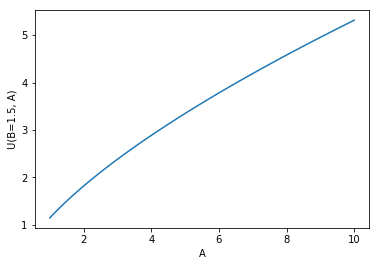

In [2]:
def U(A, B, alpha=1/3):
    return B**alpha * A**(1-alpha)

fig, ax = plt.subplots()
B = 1.5
A = np.linspace(1, 10, 100)
ax.plot(A, U(A, B))
ax.set_xlabel("A")
ax.set_ylabel("U(B=1.5, A)")

We note that
-  $ U(B,1) $ is always higher with more $ B $, hence there is a positive marginal utility of consuming more bananas  i.e. $ \frac{d U(B,1)}{d B} > 0 $
-  The more bananas we consume, the less of a change there is the marginal utility, i.e. $ \frac{d^2 U(B,1)}{d B^2} < 0 $

If we plot both the $ B $ and the $ A $ we can see how the utility
changes with different bundles

Text(0.5, 1.0, 'U(A,B)')

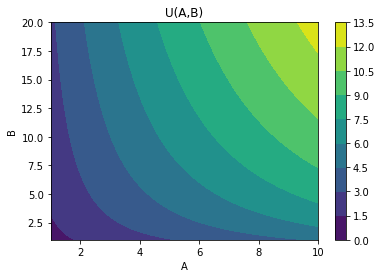

In [3]:
fig, ax = plt.subplots()
B = np.linspace(1, 20, 100).reshape((100, 1))
contours = ax.contourf(A, B.flatten(), U(A, B))
fig.colorbar(contours)
ax.set_xlabel("A")
ax.set_ylabel("B")
ax.set_title("U(A,B)")

We can analyze which bundles the consumer would be indifferent between, which
is found by fixing a utility $ \bar{U} $ and by finding all of the
combinations of $ A $ and $ B $ where $ \bar{U} = U(B, A) $

In this example, we can implement this calculation by letting $ B $ be the
variable on the x-axis, and solving for $ A(\bar{U}, B) $

$$
A(B, \bar{U}) = U^{\frac{1}{1-\alpha}}B^{\frac{-\alpha}{1-\alpha}}
$$

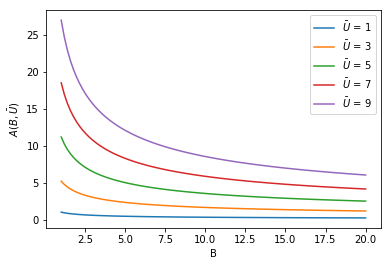

In [4]:
def A_indifference(B, ubar, alpha=1/3):
    return ubar**(1/(1-alpha)) * B**(-alpha/(1-alpha))

def plot_indifference_curves(ax, alpha=1/3):
    ubar = np.arange(1, 11, 2)
    ax.plot(B, A_indifference(B, ubar, alpha))
    ax.legend([r"$\bar{U}$" + " = {}".format(i) for i in ubar])
    ax.set_xlabel("B")
    ax.set_ylabel(r"$A(B, \bar{U}$)")

fig, ax = plt.subplots()
plot_indifference_curves(ax)

Note that in every case, if you increase either the number of apples or bananas
(holding the other fixed) then you reach a higher indifference curve

Consequently, in a world without scarcity or budgets, to maximize their utility
they would consume an arbitrarily high number of both

#### Budget Constraints

While the above example is plotting out the preferences for the consumer, it
says nothing about what they can afford

The simplest sort of constraint is a budget constraint where bananas and apples
both have a price, and the consumer has a budget

If the prices are identical per banana and per apple, no matter how many you
consume, then the set of affordable bundles is directly below a line

For example, if consumer has a budget of $ W $, the price of apples is
$ p_A = \$2 $ per apple, and the price of bananas is normalized to be
$ p_B = \$1 $ per banana, then the consumer can afford anything below the
line

$$
p_A A + B \leq W
$$

Or, letting $ W = 20 $ and plotting

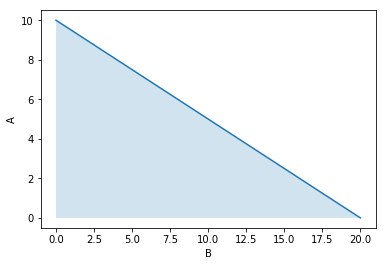

In [5]:
def maximum_A_bc(B, W=20, pa=2):
    "Given B, W, and pa return the max amount of A our consumer can afford"
    return (W - B) / pa

def plot_budget_constraint(ax, W=20, pa=2):
    B_bc = np.array([0, W])
    A_bc = maximum_A_bc(B_bc, W, pa)
    ax.plot(B_bc, A_bc)
    ax.fill_between(B_bc, 0, A_bc, alpha=0.2)
    ax.set_xlabel("B")
    ax.set_ylabel("A")
    return ax

fig, ax = plt.subplots()
plot_budget_constraint(ax, 20, 2)

While the consumer can afford any of the bundles in that area, most will not be optimal

#### Optimal Choice

Putting the budget constraints and the utility functions together lets us
visualize the optimal decision of a consumer:  choose the bundle with the
highest possible indifference curve within their budget set

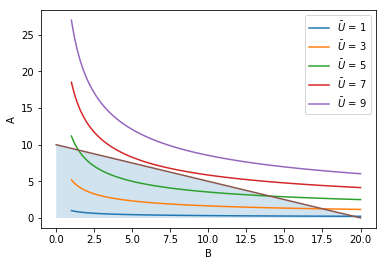

In [6]:
fig, ax = plt.subplots()
plot_indifference_curves(ax)
plot_budget_constraint(ax)

There are several ways to find the particular point $ A, B $ which
maximizes utility, such as finding the point where the indifferent point and
the budget constraint have the same slope, but a simple approach is to just
solve the direct maximization problem

$$
\begin{aligned}
\max_{A, B} & B^{\alpha}A^{1-\alpha}\\
\text{s.t. } & p_A A + B = W
\end{aligned}
$$

We will solve this using the function `scipy.optimize.minimize_scalar`, which
takes a function `f(x)` and returns the value of `x` that minimizes `f`

In [7]:
from scipy.optimize import minimize_scalar

def objective(B, W=20, pa=2):
    """
    Return value of -U for a given B, when we consume as much A as possible

    Note that we return -U because scipy wants to minimize functions
    and the value of B that minimizes -U will maximize U
    """
    A = maximum_A_bc(B, W, pa)
    return -U(A, B)

result = minimize_scalar(objective)
optimal_B = result.x
optimal_A = maximum_A_bc(optimal_B, 20, 2)
optimal_U = U(optimal_A, optimal_B)

print("The optimal U is ", optimal_U)
print("and was found at (A,B) =", (optimal_A, optimal_B))

The optimal U is  6.666666666666667
and was found at (A,B) = (6.666666630651958, 6.666666738696083)


This allows us to do experiments, such as examining how consumption patterns
change as prices or wealth levels change

**TODO** Plot a graph with the optimal ratio of B to A a function of W
**TODO** Plot a graph of both the B and A as a function of p_A

**TODO assignment?** See how the marginal utility changes as you take alpha towards 0 or 1, and explain.  Then look at how the indifference curves change.
**TODO assignment?** Numerically demonstrate the wealth effect and the income effect in a graph using the optimization approach.  Maybe look at another utility function such as log utility?

#### Satiation Point

While the above example is a particular utility function where consumers prefer to “eat” as much as possible of every good available, that may not be the case for all preferences

When an optima exists for the unconstrained problem (e.g. with an infinite budget)  it is called a bliss point

Instead of bananas and apples, consider a utility function for potato chips (`P`) and chocolate bars (`C`)

$$
U(P, C) = (P - 20)^2 + 2 * (C - 1)^2
$$

To numerically calculate the maximum (which you can probably see through inspection)

**TODO** Solve the unconstrained optimization

Of course, they may not be able to reach the bliss point for a particular budget and prices

**TODO** Solve the constrained problem with this budget constraint, and plot the P and C as a function of W… should see it stop at the bliss point

### Multivariate calculus

Partial derivative…

The Jacobian is the multivariate verson of a first derivative. It is a vector that tells us the the
partial derivative of our function with respect to each of the function inputs

$$
\mathcal{J}(x) = \begin{bmatrix} \frac{\partial f}{\partial x_1} \\
                                 \frac{\partial f}{\partial x_2} \\
                                 \vdots \\
                                 \frac{\partial f}{\partial x_N} \\
                 \end{bmatrix}
$$

The Hessian is the multivariate version of the second derivative. It is a matrix that tells us all
of the cross-partial second derivatives of the function inputs

$$
\mathcal{J}(x) = \begin{bmatrix}
    \frac{\partial f}{\partial x_1 x_1} & \frac{\partial f}{\partial x_1 x_2} & \dots & \frac{\partial f}{\partial x_1 x_N} \\
    \frac{\partial f}{\partial x_2 x_1} & \frac{\partial f}{\partial x_2 x_2} & \dots & \frac{\partial f}{\partial x_2 x_N} \\
    \vdots & \vdots & \vdots & \vdots \\
    \frac{\partial f}{\partial x_N x_1} & \frac{\partial f}{\partial x_N x_2} & \dots & \frac{\partial f}{\partial x_N x_N} \\
                 \end{bmatrix}
$$

Insert portfolio or consumption optimization problem

### Numerical optimization

We have seen how one can find solutions to some optimization problems using pen and paper, but not
all solutions will be so simple. Often the only practical way to solve an optimization problem will
be to ask the computer to solve it

Since it is useful to get a rough idea for what is going on behind the scenes, we’ll introduce one
of the most common numerical algorithms used in optimization: gradient descent

The idea